In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from py_fatigue.utils import numba_bisect
from py_fatigue.material.sn_curve import sn_curve_residuals
from py_fatigue.damage.stress_life import calc_theil_cycles_to_failure
from py_fatigue import SNCurve


In [3]:
# knee_points = """
#               1, 321
#              10, 320
#             300, 310
#           1_000, 308
#           5_039, 303
#          11_771, 299
#          23_357, 275
#          39_967, 250
#          73_176, 213
#         119_377, 182
#         207_880, 150
#         350_376, 119
#         553_241, 101
#         963_397,  86
#       1_733_270,  74
#       3_221_789,  65
#       7_525_202,  56
#      15_937_828,  50
#      32_671_572,  45
#      73_861_998,  41
#     172_521_054,  37
#     430_133_471,  34
#   1_182_699_719,  32
#   2_673_778_988,  30
#   5_850_681_784,  28
#  13_665_563_053,  26
#  28_013_567_611,  25
#  53_798_384_034,  24
# 121_624_268_965,  23
# """

# # Convert the string data to a list of lists
# knee_points_list = [list(map(float, line.split(',')))
#                     for line in knee_points.strip().split('\n')]
# knee_points_list = np.array(knee_points_list)

# curve_fkp = SNCurve.from_knee_points(
#     knee_stress=knee_points_list[:,1],
#     knee_cycles=knee_points_list[:,0],
#     endurance=1E11,
#     norm="Custom",
#     curve="From Knee Points",
#     environment="Interpolated",
# )
# curve_fkp.plot()

# slope = curve_fkp.slope
# intercept = curve_fkp.intercept
# endurance = curve_fkp.endurance


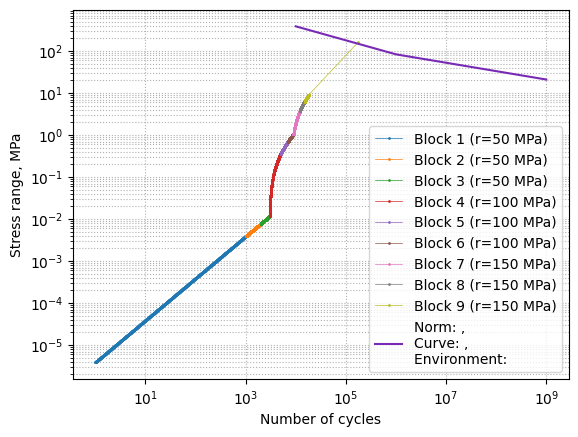

In [7]:
# --- Example usage ---
n_blocks = 3
stress_range = np.array([50, 100, 150])
count_cycle = np.array([1000, 2000, 3000])
# Increase the size of stress_range and count_cycle
stress_range = np.repeat(stress_range, n_blocks)
count_cycle = np.repeat(count_cycle, n_blocks)
slope=np.array([3, 5])
intercept=np.array([11.764, 15.606])
endurance=float("inf")
sn_curve = SNCurve(slope, intercept, endurance)
# N_total, history = calc_theil_cycles_to_failure(
#     stress_range, count_cycle, sn_curve
# )
# ax.set_yscale("log")
stress_dmg = calc_theil_cycles_to_failure(
    stress_range, count_cycle, sn_curve, to_failure=True
)

fig, ax = plt.subplots()
for step in stress_dmg:
    plt.semilogx(step[1], step[2], ".", ls="-", lw=.5, markersize=2, label=step[0])

sn_curve.plot(fig=fig, ax=ax)

plt.legend()
plt.show()

In [18]:
stress_dmg[list(stress_dmg.keys())[-1]]

(array([ 15001.        ,  15001.91166679,  15002.82338899, ...,
         17998.90613925,  18000.        , 177962.1282512 ]),
 array([  6.27578155,   6.27657625,   6.27737099, ...,   8.88904424,
          8.88999776, 164.01886707]))

In [ ]:
from py_fatigue.damage.stress_life import find_sn_curve_intersection

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from scipy.optimize import fsolve

# --- Basic functions ---

def calc_w(r, N_const):
    """
    Calculate the slope of the linearized damage growth curve.
    """
    return r / N_const

def calc_damage(w, n):
    """
    Compute damage as: f = w * n.
    """
    return w * n

def basquin_residual(N, k, m, w, b):
    """
    Residual for the modified Basquin equation:
        k / N^(1/m) = w * N + b.
    """
    return k / (N ** (1/m)) - (w * N + b)

# def solve_fatigue_life(k, m, w, b, N_min=1e3, N_max=1e7, tol=1e-6):
#     """
#     Solve k / N^(1/m) = w * N + b for N using bisection.
#     """
    
#     N_pred = bisect(lambda N: basquin_residual(N, k, m, w, b), N_min, N_max, xtol=tol)
#     return N_pred

def solve_fatigue_life(k, m, w, b, N_min=1e3):
    """
    Solve k / N^(1/m) = w * N + b for N using fsolve.
    """
    # Define the function to find the root of
    def equation(N):
        return basquin_residual(N, k, m, w, b)
    
    # Use fsolve to find the root, starting from N_min
    N_pred, = fsolve(equation, N_min)
    return N_pred

# --- Generalized multi-block predictor with history ---
def predict_multiblock_life_with_history(k, m, r_list, N_const_list, n_applied, num_points=50):
    """
    For L blocks (with L-1 predetermined blocks and the final block unscheduled),
    compute the total predicted fatigue life along with a history of the piecewise
    linear damage curves.
    
    Parameters:
      k           : Basquin constant.
      m           : Basquin exponent.
      r_list      : Array-like of stress levels for each block (length L).
      N_const_list: Array-like of constant-amplitude lives for each block (length L).
      n_applied   : Array-like of applied cycles in blocks 1..L-1 (length L-1).
      num_points  : Number of points per block segment for plotting.
      
    Returns:
      N_total     : Total predicted fatigue life (cycles) (i.e. end of final block).
      history     : A list of segments; each segment is a tuple (n_segment, f_segment, label)
                    where n_segment and f_segment are arrays of cycles and damage.
    """
    L = len(r_list)
    if len(N_const_list) != L:
        raise ValueError("r_list and N_const_list must have the same length.")
    if len(n_applied) != L - 1:
        raise ValueError("n_applied must have length L-1 (one value per predetermined block).")
    
    history = []
    
    # Start at 0 cycles and 0 damage.
    n_accum = 0.0
    f_effective = 0.0  # effective damage at the block end
    current_label = []
    
    # Process predetermined blocks (blocks 1 to L-1)
    for i in range(L - 1):
        w = calc_w(r_list[i], N_const_list[i])
        # For the first block, assume zero offset.
        if i == 0:
            b = 0.0
        else:
            # For block i, compute offset so that the effective damage carries over:
            # b_i = previous effective damage - (w_i * n_accum)
            b = f_effective - calc_damage(w, n_accum)
        
        n_start = n_accum
        n_end = n_accum + n_applied[i]
        n_seg = np.linspace(n_start, n_end, num_points)
        f_seg = calc_damage(w, n_seg) + b
        label = f"Block {i+1} (r={r_list[i]} MPa)"
        history.append((n_seg, f_seg, label))
        
        # Update accumulated cycles and effective damage for next block:
        n_accum = n_end
        f_effective = calc_damage(w, n_accum) + b

    # Process final block (block L)
    w_final = calc_w(r_list[-1], N_const_list[-1])
    # Compute offset for final block:
    b_final = f_effective - calc_damage(w_final, n_accum)
    print(f"b_final: {b_final}")
    print(f"f_effective: {f_effective}")
    print(f"n_accum: {n_accum}")
    print(f"w_final: {w_final}")
    # Solve modified Basquin for total cycles at final block:
    N_total = solve_fatigue_life(k, m, w_final, b_final, N_min=n_accum + 1)
    # N_total = find_sn_curve_intersection(
    #     np.array([m]), np.array([k]), np.inf, w_final, b_final, n_accum + 1, 1e7, tol=1e-6
    # )
    # N_total = N_total[0]
    n_final = N_total  # Total cycles at end of final block
    
    n_seg_final = np.linspace(n_accum, n_final, num_points)
    f_seg_final = calc_damage(w_final, n_seg_final) + b_final
    label = f"Final Block (r={r_list[-1]} MPa)"
    history.append((n_seg_final, f_seg_final, label))
    
    return N_total, history

# --- Testing with a 4-block load history and plotting ---
if __name__ == "__main__":
    # Define a 4-block load history.
    # Blocks 1 and 4 are high load; blocks 2 and 3 are lower load.
    r_list = np.array([400, 380, 360, 400])       # Stress levels (MPa)
    N_const_list = np.array([2496, 4000, 8000, 2496])  # Constant-amplitude lives (cycles)
    # Applied cycles in blocks 1 to 3 (block 4 is unscheduled)
    n_applied = np.array([799, 500, 1000])
    
    # Basquin parameters: assume m from paper and compute k from block 1:
    m = 11.16
    k = r_list[0] * (N_const_list[0] ** (1/m))
    
    # Get predicted fatigue life and history of damage evolution.
    N_total, history = predict_multiblock_life_with_history(k, m, r_list, N_const_list, n_applied)
    
    print(f"Total predicted fatigue life (cycles): {N_total:.0f}")
    
    # For reference, compute the S/N curve: f_SN = k / N^(1/m)
    # We'll plot from n=1 to N_total.
    N_vals = np.linspace(1, N_total, 500)
    f_SN = k / (N_vals ** (1/m))
    
    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    # Plot each block's damage evolution segment:
    for n_seg, f_seg, label in history:
        plt.plot(n_seg, f_seg, marker='o', label=label)
    
    # Plot the S/N curve (constant amplitude curve)
    plt.plot(N_vals, f_SN, 'k--', linewidth=2, label="S/N curve (k/N^(1/m))")
    
    plt.xlabel("Accumulated Cycles (n)")
    plt.ylabel("Damage / Stress Level (MPa)")
    plt.title("4-Block Load History and S/N Curve\n(Schematic representation similar to Fig. 11)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# from py_fatigue.damage.stress_life import find_sn_curve_intersection

# inter = find_sn_curve_intersection(
#     intercept=intercept,
#     slope=slope,
#     endurance=endurance,
#     weight=1,
#     res_stress=np.array(stress_dmg[-1][1][-1]),
# )


In [ ]:
# from py_fatigue.damage.stress_life import calc_nonlinear_damage_with_dca
# dmg, cumsum_dmg, _, _ = calc_nonlinear_damage_with_dca(
#     "pavlou",
#     stress_range,
#     count_cycle,
#     sn_curve,
#     damage_bands=np.linspace(0, 1, 100),
#     limit_damage=1,
#     # plot=True,
# )

In [ ]:


# # --- Basic functions ---

# def calc_w(stress_range, sn_curve: SNCurve):
#     """
#     Calculate the slope of the linearized damage growth curve.
#     """
#     cycles_to_failure = sn_curve.get_cycles(stress_range)
#     return stress_range / cycles_to_failure


# def block_stress_range(w, n):
#     """
#     Compute damage as: f = w * n.
#     """
#     return w * n


# def solve_fatigue_life(a, m, w, b, N_min=1e0, N_max=1e10, tol=1e-6):
#     """
#     Solve (a / N)^(1/m) = w * N + b for N using bisection.
#     """
#     bisect_sn_curve_residuals = numba_bisect(sn_curve_residuals, slope=m,
#                                              intercept=a, endurance=np.inf,
#                                              weight=w, res_stress=b)
#     return bisect_sn_curve_residuals(N_min, N_max, tol=tol)

# # --- Generalized multi-block predictor with history ---
# def predict_multiblock_life_with_history(
#     stress_range, count_cycle, sn_curve: SNCurve, num_points=10
# ):
#     """
#     For L blocks (with L-1 predetermined blocks and the final block unscheduled),
#     compute the total predicted fatigue life along with a history of the piecewise
#     linear damage curves.
    
#     Parameters:
#       a           : Basquin constant.
#       m           : Basquin exponent.
#       r_list      : Array-like of stress levels for each block (length L).
#       N_const_list: Array-like of constant-amplitude lives for each block (length L).
#       n_applied   : Array-like of applied cycles in blocks 1..L-1 (length L-1).
#       num_points  : Number of points per block segment for plotting.
      
#     Returns:
#       N_total     : Total predicted fatigue life (cycles) (i.e. end of final block).
#       history     : A list of segments; each segment is a tuple (n_segment, f_segment, label)
#                     where n_segment and f_segment are arrays of cycles and damage.
#     """
    
#     history = []
    
#     # Start at 0 cycles and 0 stress range
#     n_cumsum = 0.0
#     stress_range_cumsum = 0.0  # effective stress range at the block end
    
#     # Process predetermined blocks (blocks 1 to L-1)
#     w = calc_w(stress_range, sn_curve)
#     for i in range(len(count_cycle)):
        
#         # For the first block, assume zero offset.
#         if i == 0:
#             current_stress_range = 0.0
#         else:
#             # For block i, compute offset so that the effective damage carries over:
#             current_stress_range = stress_range_cumsum - block_stress_range(w[i], n_cumsum)

#         n_start = n_cumsum
#         n_end = n_cumsum + count_cycle[i]
#         n_segment = np.logspace(np.log10(n_cumsum + 1), np.log10(n_end), num_points)
#         stress_range_segment = block_stress_range(w[i], n_segment) + current_stress_range
#         label = f"Block {i+1} (r={stress_range[i]} MPa)"
#         history.append((n_segment, stress_range_segment, label))
        
#         # Update accumulated cycles and stress range for next block:
#         n_cumsum = n_end
#         stress_range_cumsum = block_stress_range(w[i], n_cumsum) + current_stress_range

#         try:
#             # Check if the block has failed
#             N_total = solve_fatigue_life(sn_curve.intercept,
#                                          sn_curve.slope, w[i],
#                                          stress_range_cumsum,
#                                          N_min=n_cumsum + 1)
#         except ValueError as ve:
#             if "No zeros found" in str(ve):
#                 print(f"failure after {n_start} cycles")
#                 return n_cumsum, history

#     # return history
#     # Process final block (block L)
#     w_final = w[-1]
#     # Compute offset for final block:
#     stress_range_final = stress_range_cumsum - block_stress_range(w_final, n_cumsum)
#     N_total = solve_fatigue_life(
#         sn_curve.intercept, sn_curve.slope, w_final, stress_range_final, N_min=n_cumsum + 1
#     )
#     if not N_total:
#         print(f"failure between {n_start} and {n_cumsum} cycles")
#         return N_total, history

#     n_final = N_total  # Total cycles at end of final block
    
#     n_seg_final = np.logspace(np.log10(n_cumsum + 1), np.log10(n_final), num_points)
#     print(f"n_seg_final: {n_seg_final}")
#     stress_range_seg_final = block_stress_range(w_final, n_seg_final) + stress_range_final
#     print(f"stress_range_seg_final: {stress_range_seg_final}")
#     label = f"Final Block (r={stress_range[-1]} MPa)"
#     history.append((n_seg_final, stress_range_seg_final, label))
    
#     return N_total, history


In [ ]:
# knee_points = """
#               1, 321
#              10, 320
#             100, 315
#           1_000, 308
#           5_039, 303
#          11_771, 299
#          23_357, 275
#          39_967, 250
#          73_176, 213
#         119_377, 182
#         207_880, 150
#         350_376, 119
#         553_241, 101
#         963_397,  86
#       1_733_270,  74
#       3_221_789,  65
#       7_525_202,  56
#      15_937_828,  50
#      32_671_572,  45
#      73_861_998,  41
#     172_521_054,  37
#     430_133_471,  34
#   1_182_699_719,  32
#   2_673_778_988,  30
#   5_850_681_784,  28
#  13_665_563_053,  26
#  28_013_567_611,  25
#  53_798_384_034,  24
# 121_624_268_965,  23
# """

# # Convert the string data to a list of lists
# knee_points_list = [list(map(float, line.split(',')))
#                     for line in knee_points.strip().split('\n')]
# knee_points_list = np.array(knee_points_list)

# curve_fkp = SNCurve.from_knee_points(
#     knee_stress=knee_points_list[:,1],
#     knee_cycles=knee_points_list[:,0],
#     endurance=1E11,
#     norm="Custom",
#     curve="From Knee Points",
#     environment="Interpolated",
# )
# curve_fkp.plot()

# slope = curve_fkp.slope
# intercept = curve_fkp.intercept
# endurance = curve_fkp.endurance

In [ ]:
# # --- Example usage ---
# n_blocks = 3
# stress_range = np.array([50, 100, 150])
# count_cycle = np.array([1000, 2000, 3000])
# # slope=np.array([3, 5])
# # intercept=np.array([11.764, 15.606])
# # endurance=float("inf")
# sn_curve = SNCurve(slope, intercept, endurance)
# N_total, history = predict_multiblock_life_with_history(stress_range, count_cycle, sn_curve)
# # Plot all the data points alongside with the SN curve

# fig, ax = plt.subplots()

# cycles = np.logspace(3, np.log10(N_total), 100)
# ax.plot(cycles, sn_curve.get_stress(cycles), label="SN Curve")
# for n_seg, f_seg, label in history:
#     ax.plot(n_seg, f_seg, label=label)
# # ax.set_xscale("linear")
# ax.set_yscale("linear")
# ax.set_xlabel("Cycles")
# ax.set_ylabel("Damage")
# ax.legend()
# plt.show()

In [ ]:

# # --- Testing with a K-block load history and plotting ---

# # Define a K-block load history.
# r_list = np.array([400, 380, 360, 400])       # Stress levels (MPa)
# N_const_list = np.array([2496, 4000, 8000, 2496])  # Constant-amplitude lives (cycles)
# # Applied cycles in blocks 1 to 3 (block 4 is unscheduled)
# n_applied = np.array([799, 500, 1000])
# n_blocks = 100
# r_list = np.random.randint(50, 150, n_blocks)
# N_const_list = np.random.randint(2000, 10000, n_blocks)
# n_applied = np.random.randint(500, 1500, n_blocks - 1)

# # Basquin parameters: assume m from paper and compute k from block 1:
# slope=np.array([3, 5])
# intercept=np.array([11.764, 15.606])
# endurance=float("inf")
# # m = 11.16
# # k = r_list[0] * (N_const_list[0] ** (1/m))

# # Get predicted fatigue life and history of damage evolution.
# N_total, history = predict_multiblock_life_with_history(
#     slope, intercept, r_list, N_const_list, n_applied
# )

# print(f"Total predicted fatigue life (cycles): {N_total}")

# # For reference, compute the S/N curve: f_SN = k / N^(1/m)
# # We'll plot from n=1 to N_total.
# N_vals = np.logspace(0, np.log10(history[-1][0][-1]), 500)
# f_SN = k / (N_vals ** (1/m))

# # --- Plotting ---
# plt.figure(figsize=(10, 6))
# # Plot each block's damage evolution segment:
# for n_seg, f_seg, label in history:
#     plt.plot(n_seg, f_seg, lw=0.5, label=label)

# # Plot the S/N curve (constant amplitude curve)
# plt.plot(N_vals, f_SN, linewidth=1, label="S/N curve (k/N^(1/m))")

# plt.xlabel("Accumulated Cycles (n)")
# plt.ylabel("Damage / Stress Level (MPa)")
# plt.title("4-Block Load History and S/N Curve\n(Schematic representation similar to Fig. 11)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
from py_fatigue.material.sn_curve import jit_sn_curve_residuals

In [ ]:
# print("Timing sn_curve_residuals:")
# %timeit sn_curve_residuals(1E4, sn_curve.slope, sn_curve.intercept, sn_curve.endurance, 100, 1)
# print(sn_curve_residuals(1E4, sn_curve.slope, sn_curve.intercept, sn_curve.endurance, 100, 1))

In [ ]:
from py_fatigue.damage.stress_life import find_sn_curve_intersection

In [ ]:
print("Res Stress:", stress_dmg[-1][2][-1])
print("Res Cycles:", stress_dmg[-1][1][-1])

In [ ]:
from py_fatigue.damage.stress_life import find_sn_curve_intersection, find_sn_curve_intersection_2

inter = find_sn_curve_intersection(
    slope=sn_curve.slope,
    intercept=sn_curve.intercept,
    endurance=sn_curve.endurance,
    weight=0.00087,
    res_stress=stress_dmg[-1][2][-1],
    # n_min=stress_dmg[-1][1][-1],
    # n_max=1000 * stress_dmg[-1][1][-1],
)
print(inter)
# inter_2 = find_sn_curve_intersection_2(
#     slope=sn_curve.slope,
#     intercept=sn_curve.intercept,
#     endurance=sn_curve.endurance,
#     weight=0.00087,
#     res_stress=stress_dmg[-1][2][-1],
# )
# print(inter_2)

In [ ]:
jit_sn_curve_residuals.locals

In [ ]:
# fail - weight * cycles - res_stress
weight=stress_range[-1] / sn_curve.get_cycles(stress_range[-1])
cycles = 169.5600646263714
fail = sn_curve.get_stress(cycles)
res_stress = stress_dmg[-1][2][-1]
print(f"cycles: {cycles}, fail: {fail}, res_stress: {res_stress}, weight: {weight}")
print(fail - weight * cycles - res_stress)

In [ ]:
print(
    "JIT bisect root:",
    jit_sn_curve_residuals(
        1., 1.e6, 1e-8, 500, sn_curve.slope, sn_curve.intercept
    )
)

# Bisection
Numba implementation

In [ ]:
import numpy as np
import types
from scipy.optimize import bisect
from numba import jit, njit
import timeit

def root_func(x, *args):
    # For demonstration, we use the first additional argument.
    return x**4 - 2*x**2 - x - args[0]

def compile_specialized_bisect(f):
    """
    Returns a compiled bisection implementation for `f` that accepts extra arguments.
    """
    # Compile the passed function in nopython mode.
    compiled_f = njit()(f)
    
    def python_bisect(a, b, tol, mxiter, *args):
        its = 0
        fa = compiled_f(a, *args)
        fb = compiled_f(b, *args)

        if abs(fa) < tol:
            return a
        elif abs(fb) < tol:
            return b

        c = (a + b) / 2.0
        fc = compiled_f(c, *args)

        while abs(fc) > tol and its < mxiter:
            its += 1
            if fa * fc < 0:
                b = c
                fb = fc
            else:
                a = c
                fa = fc
            c = (a + b) / 2.0
            fc = compiled_f(c, *args)
        return c

    return njit()(python_bisect)

# Create a jitted bisection function specialized for root_func
jit_bisect_root_func = compile_specialized_bisect(root_func)

print("JIT bisect root:", jit_bisect_root_func(-0.5, 50.0, 1e-8, 500, 1))


def numba_bisect(f, a, b, tol=1e-8, mxiter=500, *args):
    """
    A wrapper that compiles `f` if it is a regular Python function,
    and calls the bisection routine with additional arguments.
    """
    if isinstance(f, types.FunctionType):
        jit_bisect_func = compile_specialized_bisect(f)
        return jit_bisect_func(a, b, tol, mxiter, *args)
    else:
        return f(a, b, tol, mxiter, *args)


def python_bisect(f, a, b, tol=1e-8, mxiter=500, *args):
    """
    A pure Python implementation of the bisection algorithm that accepts extra arguments.
    """
    its = 0
    fa = f(a, *args)
    fb = f(b, *args)

    if abs(fa) < tol:
        return a
    elif abs(fb) < tol:
        return b

    c = (a + b) / 2.0
    fc = f(c, *args)

    while abs(fc) > tol and its < mxiter:
        its += 1
        if fa * fc < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        c = (a + b) / 2.0
        fc = f(c, *args)
    return c


# Measure the execution time and verify results.
print("Scipy bisect:", bisect(root_func, -0.5, 50.0, args=(1,)))
print("Python bisect:", python_bisect(root_func, -0.5, 50.0, 1e-8, 500, 1))
print("Numba bisect:", numba_bisect(root_func, -0.5, 50.0, 1e-8, 500, 1))

print("This is the scipy bisect")
%timeit bisect(root_func, -0.5, 50.0, args=(1,))
print("This is the python bisect")
%timeit python_bisect(root_func, -0.5, 50.0, 1e-8, 500, 1)
print("This is the numba bisect")
%timeit numba_bisect(jit_bisect_root_func, -0.5, 50.0, 1e-8, 500, 1)


In [ ]:
import numpy as np
import types
from numba import njit
import timeit

def root_func(x, *args):
    # For demonstration purposes, we use the first extra argument.
    return x**4 - 2*x**2 - x - args[0]

def compile_specialized_newton(f):
    """
    Returns a compiled Newton–Raphson implementation for f that accepts extra arguments.
    A finite-difference approximation is used to compute the derivative.
    """
    # Compile the function in nopython mode.
    compiled_f = njit()(f)
    
    @njit
    def python_newton(x0, tol, mxiter, *args):
        x = x0
        eps = 1e-6  # small perturbation for finite differences
        for i in range(mxiter):
            fx = compiled_f(x, *args)
            if abs(fx) < tol:
                return x
            # Compute the derivative using a central finite difference.
            dfx = (compiled_f(x + eps, *args) - compiled_f(x - eps, *args)) / (2.0 * eps)
            x = x - fx / dfx
        return x  # return the latest estimate if tol not reached
    return python_newton

# Create a jitted Newton–Raphson function specialized for root_func.
jit_newton_root_func = compile_specialized_newton(root_func)

print("JIT Newton root:", jit_newton_root_func(1.0, 1e-8, 500, 0.0))

def python_newton(f, x0, tol=1e-8, mxiter=500, *args):
    """
    A pure Python Newton–Raphson implementation that uses finite differences
    to approximate the derivative.
    """
    x = x0
    eps = 1e-6
    for i in range(mxiter):
        fx = f(x, *args)
        if abs(fx) < tol:
            return x
        dfx = (f(x + eps, *args) - f(x - eps, *args)) / (2.0 * eps)
        x = x - fx/dfx
    return x

print("Python Newton root:", python_newton(root_func, 1.0, 1e-8, 500, 1))

def numba_newton(f, x0, tol=1e-8, mxiter=500, *args):
    """
    A wrapper that compiles f if it is a regular Python function and calls the
    Newton–Raphson routine with extra arguments.
    """
    if isinstance(f, types.FunctionType):
        jit_newton_func = compile_specialized_newton(f)
        return jit_newton_func(x0, tol, mxiter, *args)
    else:
        return f(x0, tol, mxiter, *args)

print("Numba Newton root:", numba_newton(root_func, 1.0, 1e-8, 500, 1.0))

# Optional: Compare performance of the pure Python and Numba implementations.
print("This is the python newton")
%timeit python_newton(root_func, 1.0, 1e-8, 500, 1)
print("This is the numba newton")
%timeit numba_newton(root_func, 1.0, 1e-8, 500, 1)


In [ ]:
import numpy as np
import types
from numba import jit, njit
from scipy.optimize import newton  # for comparison

def root_func(x, arg):
    return x**4 - 2*x**2 - x - arg

def root_func_prime(x, arg):
    # Derivative: d/dx (x^4 - 2*x^2 - x - arg) = 4*x^3 - 4*x - 1
    return 4*x**3 - 4*x - 1

def compile_specialized_newton(f, fprime=None):
    """
    Returns a compiled Newton–Raphson implementation for function f.
    If fprime is provided, it is used; otherwise a finite-difference derivative is computed.
    """
    # Compile the function f in nopython mode.
    compiled_f = jit(nopython=True)(f)
    if fprime is not None:
        compiled_fprime = jit(nopython=True)(fprime)
    else:
        compiled_fprime = None

    def python_newton(x0, tol, mxiter, arg):
        x = x0
        for i in range(mxiter):
            fx = compiled_f(x, arg)
            if abs(fx) < tol:
                return x
            if compiled_fprime is not None:
                dfx = compiled_fprime(x, arg)
            else:
                # Finite-difference approximation
                eps = 1e-6
                dfx = (compiled_f(x + eps, arg) - compiled_f(x - eps, arg)) / (2 * eps)
            x = x - fx / dfx
        return x

    return jit(nopython=True)(python_newton)

# Create a jitted Newton–Raphson function specialized for root_func and its derivative.
jit_newton_root_func = compile_specialized_newton(root_func, root_func_prime)

print("JIT Newton–Raphson root:", jit_newton_root_func(1.0, 1e-8, 500, 0.0))


def python_newton(f, fprime, x0, tol=1e-8, mxiter=500, arg=0.0):
    """
    Pure Python Newton–Raphson implementation.
    """
    x = x0
    for i in range(mxiter):
        fx = f(x, arg)
        if abs(fx) < tol:
            return x
        dfx = fprime(x, arg)
        x = x - fx / dfx
    return x

print("Python Newton–Raphson root:", python_newton(root_func, root_func_prime, 1.0, tol=1e-8, mxiter=500, arg=0.0))


def numba_newton(f, fprime, x0, tol=1e-8, mxiter=500, arg=0.0):
    """
    A wrapper that compiles f and fprime if they are plain Python functions.
    """
    if isinstance(f, types.FunctionType) and isinstance(fprime, types.FunctionType):
        jit_newton_func = compile_specialized_newton(f, fprime)
        return jit_newton_func(x0, tol, mxiter, arg)
    else:
        return f(x0, tol, mxiter, arg)

print("Numba Newton–Raphson root:", numba_newton(root_func, root_func_prime, 1.0, tol=1e-8, mxiter=500, arg=0.0))

# Compare with SciPy's newton method for reference.
print("SciPy Newton:", newton(lambda x: root_func(x, 0.0),
                              1.0,
                              fprime=lambda x: root_func_prime(x, 0.0)))



print("This is the scipy newton")
%timeit newton(lambda x: root_func(x, 0.0), 1.0, fprime=lambda x: root_func_prime(x, 1))
print("This is the python newton")
%timeit python_newton(root_func, root_func_prime, 1.0, tol=1e-8, mxiter=500, arg=1)
print("This is the numba newton")
%timeit numba_newton(root_func, root_func_prime, 1.0, tol=1e-8, mxiter=500, arg=1)

In [ ]:
import numpy as np
import types
from scipy.optimize import bisect
from numba import f8, jit, njit


#---------------------------------------------------------------------#
# Thank you to Stan Seibert from the Numba team for help with this
#---------------------------------------------------------------------#
def root_func(x):
    return x**4 - 2*x**2 - x - 3


def compile_specialized_bisect(f):
    """
    Returns a compiled bisection implementation for ``f``.
    """

    def python_bisect(a, b, tol, mxiter):
        """
        Beautiful Docstring ...
        Parameters
        ----------
        a : scalar(int)
            An initial guess
        b : scalar(int)
            An initial guess
        tol : scalar(float)
            The convergence tolerance
        mxiter : scalar(int)
            Max number of iterations to allow
        Note: f(a) should be less than 0 and f(b) should be greater than 0.
              I removed the checks to simplify code.
        """
        its = 0
        fa = jit_root_func(a)
        fb = jit_root_func(b)

        if abs(fa) < tol:
            return a
        elif abs(fb) < tol:
            return b


        c = (a+b)/2.
        fc = jit_root_func(c)

        while abs(fc)>tol and its<mxiter:

            its = its + 1

            if fa*fc < 0:
                b = c
                fb = fc

            else:
                a = c
                fa = fc

            c = (a+b)/2.
            fc = jit_root_func(c)

        return c

    # Have to give explicit type signature for root function to be able
    # to call this function from another nopython function
    jit_root_func = jit('float64(float64)', nopython=True)(root_func)
    return jit(nopython=True)(python_bisect)

jit_bisect_root_func = compile_specialized_bisect(root_func)

print(jit_bisect_root_func(-.5, 50., 1e-8, 500))

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#


def numba_bisect(f, a, b, tol=1e-8, mxiter=500):
    """
    Wraps this stuff up into a single function
    """
    if isinstance(f, types.FunctionType):
        jit_bisect_root_func = compile_specialized_bisect(f)
        return jit_bisect_root_func(a, b, tol, mxiter)
    else:
        return f(a, b, tol, mxiter)


def python_bisect(f, a, b, tol=1e-8, mxiter=500):
    """
    Beautiful Docstring ...
    Parameters
    ----------
    a : scalar(int)
        An initial guess
    b : scalar(int)
        An initial guess
    tol : scalar(float)
        The convergence tolerance
    mxiter : scalar(int)
        Max number of iterations to allow
    Note: f(a) should be less than 0 and f(b) should be greater than 0.
          I removed the checks to simplify code.
    """
    its = 0
    fa = f(a)
    fb = f(b)

    if abs(fa) < tol:
        return a
    elif abs(fb) < tol:
        return b


    c = (a+b)/2.
    fc = f(c)

    while abs(fc)>tol and its<mxiter:

        its = its + 1

        if fa*fc < 0:
            b = c
            fb = fc

        else:
            a = c
            fa = fc

        c = (a+b)/2.
        fc = f(c)

    return c


jit_bisect_root_func = compile_specialized_bisect(root_func)

print(bisect(root_func, -0.5, 50.))
print(python_bisect(root_func, -0.5, 50.))
print(numba_bisect(root_func, -0.5, 50.))

print("This is the scipy bisect")
%timeit bisect(root_func, -.5, 50.)
print("This is the python bisect")
%timeit python_bisect(root_func, -0.5, 50.)
print("This is the numba bisect")
%timeit numba_bisect(jit_bisect_root_func, -0.5, 50.)